# **SpaceX Falcon 9 first stage Landing Prediction**

In [1]:
import requests
import pandas as pd
import numpy as np
# Datetime is a library that allows us to represent dates
import datetime
# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [2]:
spacex_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json"
response = requests.get(spacex_url)
response.status_code

200

In [3]:
data=pd.json_normalize(response.json())

In [4]:
data.head()

,static_fire_date_utc,static_fire_date_unix,tbd,net,window,rocket,success,details,crew,ships,capsules,payloads,launchpad,auto_update,failures,flight_number,name,date_utc,date_unix,date_local,date_precision,upcoming,cores,id,fairings.reused,fairings.recovery_attempt,fairings.recovered,fairings.ships,links.patch.small,links.patch.large,links.reddit.campaign,links.reddit.launch,links.reddit.media,links.reddit.recovery,links.flickr.small,links.flickr.original,links.presskit,links.webcast,links.youtube_id,links.article,links.wikipedia,fairings
0,2006-03-17T00:00:00.000Z,1.142554e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Engine failure at 33 seconds and loss of vehicle,[],[],[],[5eb0e4b5b6c3bb0006eeb1e1],5e9e4502f5090995de566f86,True,"[{'time': 33, 'altitude': None, 'reason': 'merlin engine failure'}]",1,FalconSat,2006-03-24T22:30:00.000Z,1143239400,2006-03-25T10:30:00+12:00,hour,False,"[{'core': '5e9e289df35918033d3b2623', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cd9ffd86e000604b32a,False,False,False,[],https://images2.imgbox.com/3c/0e/T8iJcSN3_o.png,https://images2.imgbox.com/40/e3/GypSkayF_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=0a_00nJ_Y88,0a_00nJ_Y88,https://www.space.com/2196-spacex-inaugural-falcon-1-rocket-lost-launch.html,https://en.wikipedia.org/wiki/DemoSat,NaN
1,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,"Successful first stage burn and transition to second stage, maximum altitude 289 km, Premature engine shutdown at T+7 min 30 s, Failed to reach orbit, Failed to recover first stage",[],[],[],[5eb0e4b6b6c3bb0006eeb1e2],5e9e4502f5090995de566f86,True,"[{'time': 301, 'altitude': 289, 'reason': 'harmonic oscillation leading to premature engine shutdown'}]",2,DemoSat,2007-03-21T01:10:00.000Z,1174439400,2007-03-21T13:10:00+12:00,hour,False,"[{'core': '5e9e289ef35918416a3b2624', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdaffd86e000604b32b,False,False,False,[],https://images2.imgbox.com/4f/e3/I0lkuJ2e_o.png,https://images2.imgbox.com/be/e7/iNqsqVYM_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=Lk4zQ2wP-Nc,Lk4zQ2wP-Nc,https://www.space.com/3590-spacex-falcon-1-rocket-fails-reach-orbit.html,https://en.wikipedia.org/wiki/DemoSat,NaN
2,None,NaN,False,False,0.0,5e9d0d95eda69955f709d1eb,False,Residual stage 1 thrust led to collision between stage 1 and stage 2,[],[],[],"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006eeb1e4]",5e9e4502f5090995de566f86,True,"[{'time': 140, 'altitude': 35, 'reason': 'residual stage-1 thrust led to collision between stage 1 and stage 2'}]",3,Trailblazer,2008-08-03T03:34:00.000Z,1217734440,2008-08-03T15:34:00+12:00,hour,False,"[{'core': '5e9e289ef3591814873b2625', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_success': None, 'landing_type': None, 'landpad': None}]",5eb87cdbffd86e000604b32c,False,False,False,[],https://images2.imgbox.com/3d/86/cnu0pan8_o.png,https://images2.imgbox.com/4b/bd/d8UxLh4q_o.png,None,None,None,None,[],[],None,https://www.youtube.com/watch?v=v0w9p3U8860,v0w9p3U8860,http://www.spacex.com/news/2013/02/11/falcon-1-flight-3-mission-summary,https://en.wikipedia.org/wiki/Trailblazer_(satellite),NaN
3,2008-09-20T00:00:00.000Z,1.221869e+09,False,False,0.0,5e9d0d95eda69955f709d1eb,True,"Ratsat was carried to orbit on the first successful orbital launch of any privately funded and developed, liquid-propelled carrier rocket, the SpaceX Falcon 1",[],[],[],[5eb0e4b7b6c3bb0006eeb1e5],5e9e4502f5090995de566f86,True,[],4,RatSat,2008-09-28T23:15:00.000Z,1222643700,2008-09-28T11:15:00+12:00,hour,False,"[{'core': '5e9e289ef3591855dc3b2626', 'flight': 1, 'gridfins': False, 'legs': False, 'reused': False, 'landing_attempt': False, 'landing_succes

In [5]:
data.shape

(107, 42)

In [6]:
# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [7]:
#Global variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

In [8]:
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])

def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])

def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [9]:
getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [10]:
launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

In [11]:
df=pd.DataFrame(launch_dict)
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


In [12]:
data_falcon9=df[df['BoosterVersion']=='Falcon 9']
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,8,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,10,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,11,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,12,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,102,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,103,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,104,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,105,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [13]:
data_falcon9.loc[:,'FlightNumber'] = list(range(1, data_falcon9.shape[0]+1))
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
4,1,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857
5,2,2012-05-22,Falcon 9,525.0,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857
6,3,2013-03-01,Falcon 9,677.0,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857
7,4,2013-09-29,Falcon 9,500.0,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093
8,5,2013-12-03,Falcon 9,3170.0,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058
90,87,2020-10-06,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058
91,88,2020-10-18,Falcon 9,15600.0,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058
92,89,2020-10-24,Falcon 9,15600.0,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857


In [14]:
data_falcon9.isnull().sum()

,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,5
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


In [15]:
mean=data_falcon9['PayloadMass'].mean(axis=0)
# Replace the np.nan values with its mean value
data_falcon9['PayloadMass'].replace(np.nan,mean,inplace=True)
data_falcon9.isnull().sum()

/tmp/ipython-input-2258576036.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_falcon9['PayloadMass'].replace(np.nan,mean,inplace=True)
/tmp/ipython-input-2258576036.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['PayloadMass'].replace(np.nan,mean,inplace=True)


,0
FlightNumber,0
Date,0
BoosterVersion,0
PayloadMass,0
Orbit,0
LaunchSite,0
Outcome,0
Flights,0
GridFins,0
Reused,0


In [16]:
data_falcon9.isnull().sum()/len(data_falcon9)*100

,0
FlightNumber,0.000000
Date,0.000000
BoosterVersion,0.000000
PayloadMass,0.000000
Orbit,0.000000
LaunchSite,0.000000
Outcome,0.000000
Flights,0.000000
GridFins,0.000000
Reused,0.000000


In [17]:
data_falcon9.dtypes

,0
FlightNumber,int64
Date,object
BoosterVersion,object
PayloadMass,float64
Orbit,object
LaunchSite,object
Outcome,object
Flights,int64
GridFins,bool
Reused,bool


In [18]:
data_falcon9['LaunchSite'].value_counts()

,count
LaunchSite,
CCSFS SLC 40,55
KSC LC 39A,22
VAFB SLC 4E,13


In [19]:
data_falcon9[['LaunchSite','Orbit']].value_counts()

LaunchSite    Orbit
CCSFS SLC 40  GTO      18
              ISS      16
KSC LC 39A    GTO       9
CCSFS SLC 40  VLEO      9
VAFB SLC 4E   PO        9
KSC LC 39A    ISS       5
CCSFS SLC 40  LEO       5
KSC LC 39A    VLEO      5
VAFB SLC 4E   SSO       4
CCSFS SLC 40  MEO       3
KSC LC 39A    LEO       2
CCSFS SLC 40  HEO       1
              SSO       1
              ES-L1     1
              GEO       1
KSC LC 39A    SO        1
Name: count, dtype: int64

In [20]:
landing_outcomes=data_falcon9[['Outcome']].value_counts()
landing_outcomes

,count
Outcome,
True ASDS,41
None None,19
True RTLS,14
False ASDS,6
True Ocean,5
False Ocean,2
None ASDS,2
False RTLS,1


In [21]:
for i,outcome in enumerate(landing_outcomes.keys()):
    print(i,outcome)

0 ('True ASDS',)
1 ('None None',)
2 ('True RTLS',)
3 ('False ASDS',)
4 ('True Ocean',)
5 ('False Ocean',)
6 ('None ASDS',)
7 ('False RTLS',)


In [22]:
bad_outcomes = ['None None','False ASDS','False Ocean','None ASDS','False RTLS']
landing_class = [0 if outcome in bad_outcomes else 1 for outcome in data_falcon9['Outcome']]
data_falcon9['Class'] = landing_class
data_falcon9.head()

/tmp/ipython-input-1520336143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Class'] = landing_class


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0


In [23]:
data_falcon9['Class'].value_counts()

,count
Class,
1,60
0,30


In [24]:
data_falcon9.to_csv("Falcon9_Dataset_from_API.csv", index=False)


In [25]:
import sys

import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd

In [26]:
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                  "AppleWebKit/537.36 (KHTML, like Gecko) "
                  "Chrome/91.0.4472.124 Safari/537.36"
}

In [27]:
response = requests.get(static_url,headers=headers)
# assign the response to a object
response

<Response [200]>

In [28]:
soup=BeautifulSoup(response.text)
soup.title

<title>List of Falcon 9 and Falcon Heavy launches - Wikipedia</title>

In [29]:
def date_time(table_cells):
    """
    This function returns the data and time from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    """
    This function returns the booster version from the HTML  table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=''.join([booster_version for i,booster_version in enumerate( table_cells.strings) if i%2==0][0:-1])
    return out

def landing_status(table_cells):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    out=[i for i in table_cells.strings][0]
    return out


def get_mass(table_cells):
    mass=unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass=mass[0:mass.find("kg")+2]
    else:
        new_mass=0
    return new_mass


def extract_column_from_header(row):
    """
    This function returns the landing status from the HTML table cell
    Input: the  element of a table data cell extracts extra row
    """
    if (row.br):
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()

    colunm_name = ' '.join(row.contents)

    # Filter the digit and empty names
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name


In [30]:
html_tables=soup.find_all('table')
first_launch_table = html_tables[2]
column_names = []

# Apply find_all() function with `th` element on first_launch_table
ok=first_launch_table.find_all('th')
for th in ok:
    name=extract_column_from_header(th)
    if name is not None and len(name)>0:
        column_names.append(name)

print(column_names)

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


In [31]:
launch_dict= dict.fromkeys(column_names)

# Remove an irrelvant column
del launch_dict['Date and time ( )']

# Let's initial the launch_dict with each value to be an empty list
launch_dict['Flight_No'] = []
launch_dict['Launch_site'] = []
launch_dict['Payload'] = []
launch_dict['Payload_mass'] = []
launch_dict['Orbit'] = []
launch_dict['Customer'] = []
launch_dict['Launch_outcome'] = []
# Added some new columns
launch_dict['Version_Booster']=[]
launch_dict['Booster_landing']=[]
launch_dict['Date']=[]
launch_dict['Time']=[]

In [32]:
extracted_row = 0

# Extract each table
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        # Check if first table heading is a number corresponding to flight number
        if rows.th and rows.th.string:
            flight_number = rows.th.string.strip()
            flag = flight_number.isdigit()
        else:
            flag = False

        # Get table element
        row = rows.find_all('td')

        # If it is a valid flight row, save cells in dictionary
        if flag:
            extracted_row += 1

            # Flight Number
            launch_dict['Flight_No'].append(flight_number)

            # Date and Time
            datatimelist = date_time(row[0])
            date = datatimelist[0].strip(',')
            time = datatimelist[1]
            launch_dict['Date'].append(date)
            launch_dict['Time'].append(time)

            # Booster Version
            bv = booster_version(row[1])
            if not bv:
                bv = row[1].a.string
            launch_dict['Version_Booster'].append(bv)

            # Launch Site
            launch_site = row[2].a.string
            launch_dict['Launch_site'].append(launch_site)

            # Payload
            payload = row[3].a.string
            launch_dict['Payload'].append(payload)

            # Payload Mass
            payload_mass = get_mass(row[4])
            launch_dict['Payload_mass'].append(payload_mass)

            # Orbit
            orbit = row[5].a.string
            launch_dict['Orbit'].append(orbit)

            # Customer

            customer = row[6].a.string if row[6].a else row[6].get_text(strip=True)
            launch_dict['Customer'].append(customer)


            # Launch Outcome
            launch_outcome = list(row[7].strings)[0]
            launch_dict['Launch_outcome'].append(launch_outcome)

            # Booster Landing
            booster_landing = landing_status(row[8])
            launch_dict['Booster_landing'].append(booster_landing)


In [33]:
web_data= pd.DataFrame({ key:pd.Series(value) for key, value in launch_dict.items() })

In [34]:
web_data.to_csv('spacex_web_scraped.csv', index=False)

In [35]:
%load_ext sql

In [36]:
import csv, sqlite3
import prettytable
prettytable.DEFAULT = 'DEFAULT'

con = sqlite3.connect("my_data1.db")
cur = con.cursor()
%sql sqlite:///my_data1.db

In [37]:
df_web = pd.read_csv("/content/spacex_web_scraped.csv")
df_web.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")
df_web

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Flight_No,Launch_site,Payload_mass,Launch_outcome,Version_Booster,Booster_landing,Date,Time
0,NaN,NaN,Dragon Spacecraft Qualification Unit,NaN,LEO,SpaceX,NaN,1,CCAFS,0,Success\n,F9 v1.07B0003.18,Failure,4 June 2010,18:45
1,NaN,NaN,Dragon,NaN,LEO,NASA,NaN,2,CCAFS,0,Success,F9 v1.07B0004.18,Failure,8 December 2010,15:43
2,NaN,NaN,Dragon,NaN,LEO,NASA,NaN,3,CCAFS,525 kg,Success,F9 v1.07B0005.18,No attempt\n,22 May 2012,07:44
3,NaN,NaN,SpaceX CRS-1,NaN,LEO,NASA,NaN,4,CCAFS,"4,700 kg",Success\n,F9 v1.07B0006.18,No attempt,8 October 2012,00:35
4,NaN,NaN,SpaceX CRS-2,NaN,LEO,NASA,NaN,5,CCAFS,"4,877 kg",Success\n,F9 v1.07B0007.18,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,NaN,NaN,Starlink,NaN,LEO,SpaceX,NaN,117,CCSFS,"15,600 kg",Success\n,F9 B5B1051.10657,Success,9 May 2021,06:42
117,NaN,NaN,Starlink,NaN,LEO,SpaceX,NaN,118,KSC,"~14,000 kg",Success\n,F9 B5B1058.8660,Success,15 May 2021,22:56
118,NaN,NaN,Starlink,NaN,LEO,SpaceX,NaN,119,CCSFS,"15,600 kg",Success\n,F9 B5B1063.2665,Success,26 May 2021,18:59
119,NaN,NaN,SpaceX CRS-22,NaN,LEO,NASA,NaN,120,KSC,"3,328 kg",Success\n,F9 B5B1067.1668,Success,3 June 2021,17:29


In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
df.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude
0,1,2006-03-24,Falcon 1,20.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin1A,167.743129,9.047721
1,2,2007-03-21,Falcon 1,NaN,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2A,167.743129,9.047721
2,4,2008-09-28,Falcon 1,165.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin2C,167.743129,9.047721
3,5,2009-07-13,Falcon 1,200.0,LEO,Kwajalein Atoll,None None,1,False,False,False,None,NaN,0,Merlin3C,167.743129,9.047721
4,6,2010-06-04,Falcon 9,NaN,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857


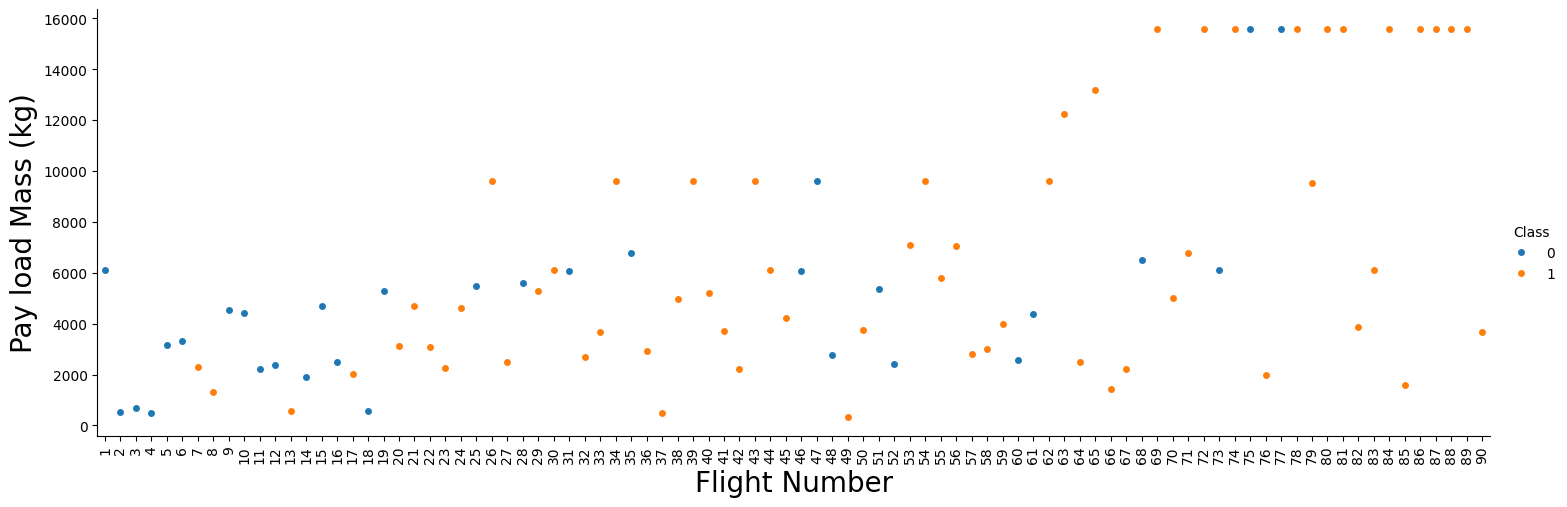

In [40]:
sns.catplot(y="PayloadMass", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 3)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("Pay load Mass (kg)",fontsize=20)
plt.xticks(rotation=90)
plt.show()

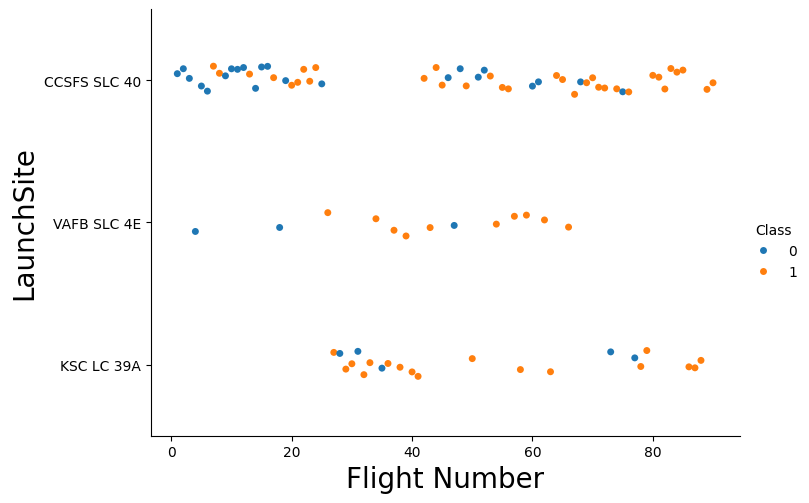

In [41]:
sns.catplot(y="LaunchSite", x="FlightNumber", hue="Class", data=data_falcon9, aspect = 1.5)
plt.xlabel("Flight Number",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()

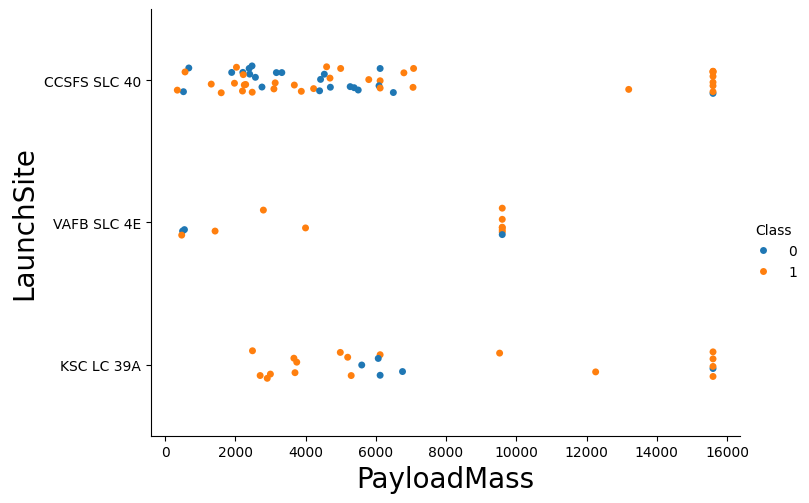

In [42]:
sns.catplot(y="LaunchSite", x="PayloadMass", hue="Class", data=data_falcon9, aspect = 1.5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("LaunchSite",fontsize=20)
plt.show()


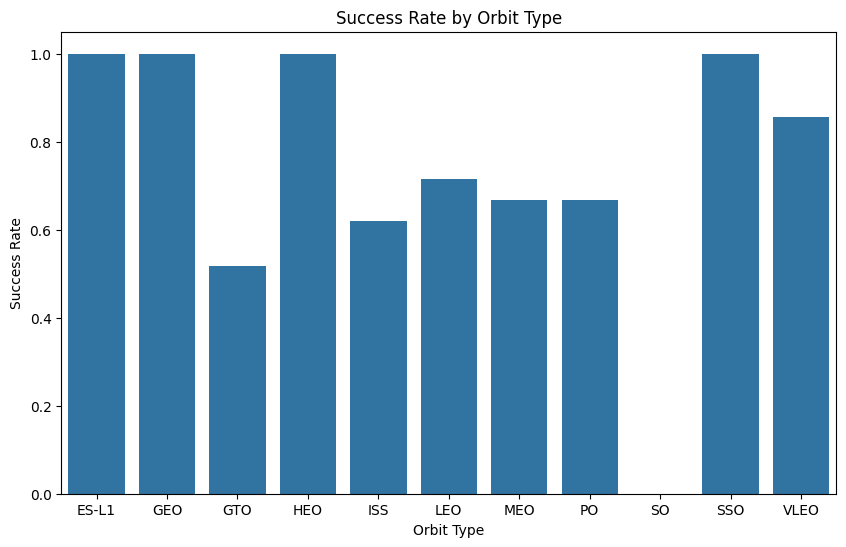

In [43]:
success_rate = data_falcon9.groupby('Orbit')['Class'].mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(x='Orbit', y='Class', data=success_rate)
plt.title('Success Rate by Orbit Type')
plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.show()

In [44]:
success_rate


,Orbit,Class
0,ES-L1,1.000000
1,GEO,1.000000
2,GTO,0.518519
3,HEO,1.000000
4,ISS,0.619048
5,LEO,0.714286
6,MEO,0.666667
7,PO,0.666667
8,SO,0.000000
9,SSO,1.000000


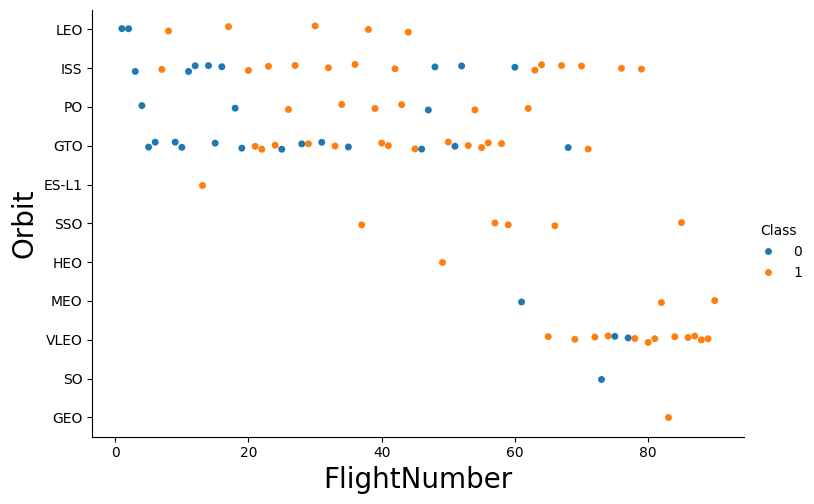

In [45]:
sns.catplot(y="Orbit", x="FlightNumber", hue="Class", data=data_falcon9,aspect=1.5)
plt.xlabel("FlightNumber",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

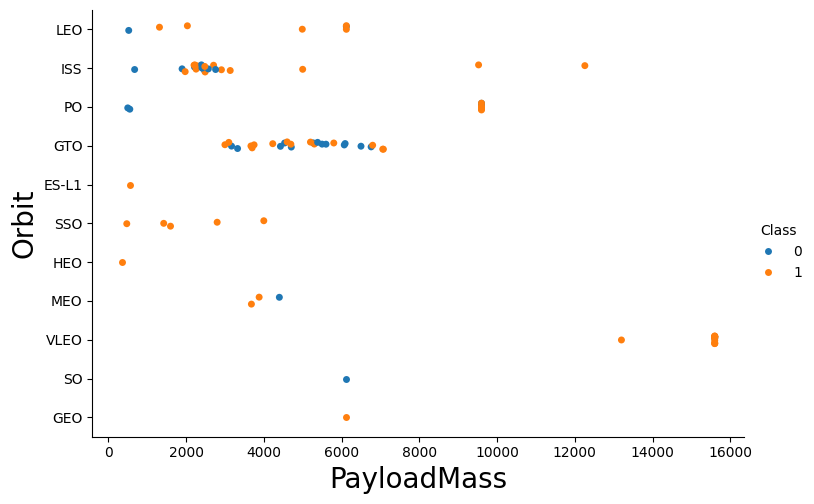

In [46]:
sns.catplot(y="Orbit", x="PayloadMass", hue="Class", data=data_falcon9,aspect=1.5)
plt.xlabel("PayloadMass",fontsize=20)
plt.ylabel("Orbit",fontsize=20)
plt.show()

In [47]:
data_falcon9['Year'] = pd.to_datetime(data_falcon9['Date']).dt.year
data_falcon9.head()

/tmp/ipython-input-3722963265.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['Year'] = pd.to_datetime(data_falcon9['Date']).dt.year


,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013


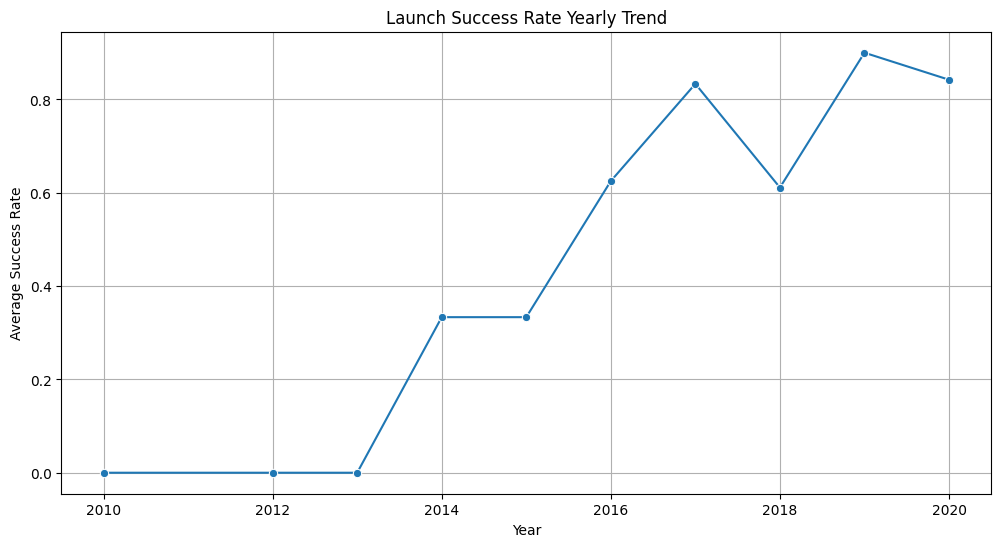

In [48]:
yearly_success = data_falcon9.groupby('Year')['Class'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(x='Year', y='Class', data=yearly_success, marker='o')
plt.title('Launch Success Rate Yearly Trend')
plt.xlabel('Year')
plt.ylabel('Average Success Rate')
plt.grid(True)
plt.show()

In [49]:
import folium
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon


In [50]:
launch_sites_df = data_falcon9.groupby(['LaunchSite'], as_index=False).first()
launch_sites_df = launch_sites_df[['LaunchSite', 'Latitude', 'Longitude']]
launch_sites_df

,LaunchSite,Latitude,Longitude
0,CCSFS SLC 40,28.561857,-80.577366
1,KSC LC 39A,28.608058,-80.603956
2,VAFB SLC 4E,34.632093,-120.610829


In [51]:
world_map=folium.Map()
incidents=folium.map.FeatureGroup()
for lat,Long in zip(launch_sites_df['Latitude'],launch_sites_df['Longitude']):
    incidents.add_child(folium.vector_layers.CircleMarker([lat,Long],radius=20,color='yellow',fill=True,fill_color='blue')
                       )
world_map.add_child(incidents)

In [52]:
marker_cluster = MarkerCluster()
data_falcon9['marker_color']=['green' if class_==1 else 'red' for class_ in data_falcon9['Class'] ]

/tmp/ipython-input-616674120.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_falcon9['marker_color']=['green' if class_==1 else 'red' for class_ in data_falcon9['Class'] ]


In [53]:
world_map.add_child(marker_cluster)
for Lat,Long, name,col in zip (data_falcon9['Latitude'],data_falcon9['Longitude'],data_falcon9['LaunchSite'],data_falcon9['marker_color']):
    marker=folium.Marker([Lat, Long],icon=folium.Icon(color='white', icon_color=col,popup=name))
    marker_cluster.add_child(marker)

world_map

In [54]:
data_falcon9

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class,Year,marker_color
4,1,2010-06-04,Falcon 9,6123.547647,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0003,-80.577366,28.561857,0,2010,red
5,2,2012-05-22,Falcon 9,525.000000,LEO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0005,-80.577366,28.561857,0,2012,red
6,3,2013-03-01,Falcon 9,677.000000,ISS,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B0007,-80.577366,28.561857,0,2013,red
7,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,None,1.0,0,B1003,-120.610829,34.632093,0,2013,red
8,5,2013-12-03,Falcon 9,3170.000000,GTO,CCSFS SLC 40,None None,1,False,False,False,None,1.0,0,B1004,-80.577366,28.561857,0,2013,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,2020-09-03,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060,-80.603956,28.608058,1,2020,green
90,87,2020-10-06,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058,-80.603956,28.608058,1,2020,green
91,88,2020-10-18,Falcon 9,15600.000000,VLEO,KSC LC 39A,True ASDS,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051,-80.603956,28.608058,1,2020,green
92,89,2020-10-24,Falcon 9,15600.000000,VLEO,CCSFS SLC 40,True ASDS,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060,-80.577366,28.561857,1,2020,green


In [55]:
features = data_falcon9[['FlightNumber', 'PayloadMass', 'Orbit', 'LaunchSite', 'Flights', 'GridFins', 'Reused', 'Legs', 'LandingPad', 'Block', 'ReusedCount', 'Serial']]
features

,FlightNumber,PayloadMass,Orbit,LaunchSite,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial
4,1,6123.547647,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0003
5,2,525.000000,LEO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0005
6,3,677.000000,ISS,CCSFS SLC 40,1,False,False,False,None,1.0,0,B0007
7,4,500.000000,PO,VAFB SLC 4E,1,False,False,False,None,1.0,0,B1003
8,5,3170.000000,GTO,CCSFS SLC 40,1,False,False,False,None,1.0,0,B1004
...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,15600.000000,VLEO,KSC LC 39A,2,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1060
90,87,15600.000000,VLEO,KSC LC 39A,3,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,13,B1058
91,88,15600.000000,VLEO,KSC LC 39A,6,True,True,True,5e9e3032383ecb6bb234e7ca,5.0,12,B1051
92,89,15600.000000,VLEO,CCSFS SLC 40,3,True,True,True,5e9e3033383ecbb9e534e7cc,5.0,12,B1060


In [56]:
features.to_csv('spacex_launch_data.csv')

In [57]:
df_web.dtypes

,0
Flight No.,float64
Launch site,float64
Payload,object
Payload mass,float64
Orbit,object
Customer,object
Launch outcome,float64
Flight_No,int64
Launch_site,object
Payload_mass,object


In [58]:
data_falcon9.dtypes

,0
FlightNumber,int64
Date,object
BoosterVersion,object
PayloadMass,float64
Orbit,object
LaunchSite,object
Outcome,object
Flights,int64
GridFins,bool
Reused,bool


In [59]:

categorical_cols = ['Orbit', 'LaunchSite','GridFins','Reused', 'Legs','LandingPad', 'Serial']

# Create dummy variables
features_one_hot = pd.get_dummies(features, columns=categorical_cols,dtype=int)
# Display the first few rows
features_one_hot.astype(float)
features_one_hot.isnull().sum()


,0
FlightNumber,0
PayloadMass,0
Flights,0
Block,0
ReusedCount,0
...,...
Serial_B1056,0
Serial_B1058,0
Serial_B1059,0
Serial_B1060,0


In [60]:
features_one_hot

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,Orbit_LEO,Orbit_MEO,Orbit_PO,Orbit_SO,Orbit_SSO,Orbit_VLEO,LaunchSite_CCSFS SLC 40,LaunchSite_KSC LC 39A,LaunchSite_VAFB SLC 4E,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True,LandingPad_5e9e3032383ecb267a34e7c7,LandingPad_5e9e3032383ecb554034e7c9,LandingPad_5e9e3032383ecb6bb234e7ca,LandingPad_5e9e3032383ecb761634e7cb,LandingPad_5e9e3033383ecbb9e534e7cc,Serial_B0003,Serial_B0005,Serial_B0007,Serial_B1003,Serial_B1004,Serial_B1005,Serial_B1006,Serial_B1007,Serial_B1008,Serial_B1010,Serial_B1011,Serial_B1012,Serial_B1013,Serial_B1015,Serial_B1016,Serial_B1017,Serial_B1018,Serial_B1019,Serial_B1020,Serial_B1021,Serial_B1022,Serial_B1023,Serial_B1025,Serial_B1026,Serial_B1028,Serial_B1029,Serial_B1030,Serial_B1031,Serial_B1032,Serial_B1034,Serial_B1035,Serial_B1036,Serial_B1037,Serial_B1038,Serial_B1039,Serial_B1040,Serial_B1041,Serial_B1042,Serial_B1043,Serial_B1044,Serial_B1045,Serial_B1046,Serial_B1047,Serial_B1048,Serial_B1049,Serial_B1050,Serial_B1051,Serial_B1054,Serial_B1056,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062
4,1,6123.547647,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,525.000000,1,1.0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,3,677.000000,1,1.0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,4,500.000000,1,1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,5,3170.000000,1,1.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,86,15600.000000,2,5.0,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
90,87,15600.000000,3,5.0,13,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
91,88,15600.000000,6,5.0,12,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
92,89,15600.000000,3,5.0,12,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [61]:
import joblib

In [62]:
training_columns=features_one_hot.columns.tolist()
joblib.dump(training_columns,'training_columns.pkl')

['training_columns.pkl']

In [63]:
x=features_one_hot
y=data_falcon9['Class'].to_numpy()

In [64]:
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

In [65]:
from sklearn.preprocessing import StandardScaler

In [66]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [67]:
scalar=StandardScaler()
X_train_scaled=scalar.fit_transform(X_train)
X_test_scaled=scalar.fit_transform(X_test)

In [68]:
joblib.dump(scalar,'scalar.pkl')

['scalar.pkl']

In [69]:
parameters ={'C':[0.01,0.1,1],
             'penalty':['l2'],
             'solver':['lbfgs']}

In [70]:
lr=LogisticRegression()
lr.fit(X_train_scaled,Y_train)
y_pred=lr.predict(X_test_scaled)
logreg_cv=GridSearchCV(lr,parameters,cv=10)
logreg_cv.fit(X_train_scaled, Y_train)

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1], 'penalty': ['l2'],
                         'solver': ['lbfgs']})

In [71]:
logreg_cv.best_estimator_
logreg_cv.best_params_


{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

In [72]:
lr.score(X_test_scaled,Y_test)

0.8888888888888888

In [73]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix');
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed'])
    plt.show()

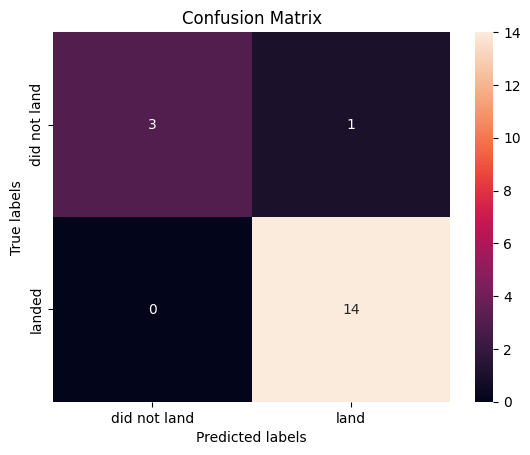

In [74]:
yhat_logreg=logreg_cv.predict(X_test_scaled)
plot_confusion_matrix(Y_test,yhat_logreg)

In [75]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [76]:
svm_cv = GridSearchCV(svm, parameters, cv=10)
svm_cv.fit(X_train_scaled, Y_train)

GridSearchCV(cv=10, estimator=SVC(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'gamma': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'kernel': ('linear', 'rbf', 'poly', 'rbf', 'sigmoid')})

In [77]:
svm_cv.score(X_test_scaled,Y_test)

0.8888888888888888

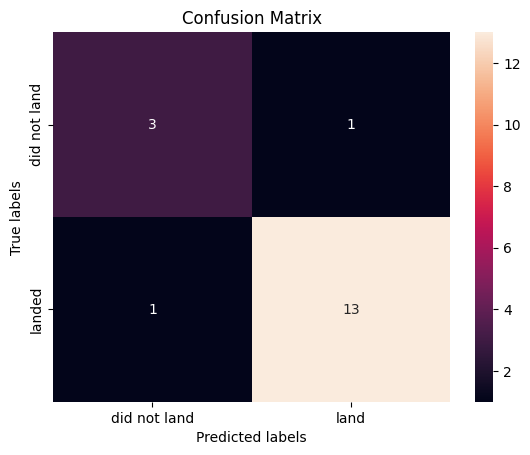

In [78]:
yhat_svm=svm_cv.predict(X_test_scaled)
plot_confusion_matrix(Y_test,yhat_svm)

In [79]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [80]:
tree_cv = GridSearchCV(tree, parameters, cv=10)
tree_cv.fit(X_train_scaled, Y_train)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/u

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']})

In [81]:
tree_cv.score(X_test_scaled,Y_test)

0.8888888888888888

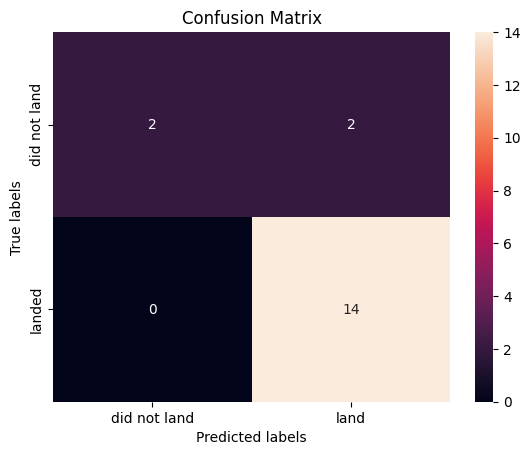

In [82]:
yhat_tree = tree_cv.predict(X_test_scaled)
plot_confusion_matrix(Y_test,yhat_tree)

In [83]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [84]:
knn_cv=GridSearchCV(KNN,parameters,cv=10)
knn_cv.fit(X_train_scaled,Y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [1, 2]})

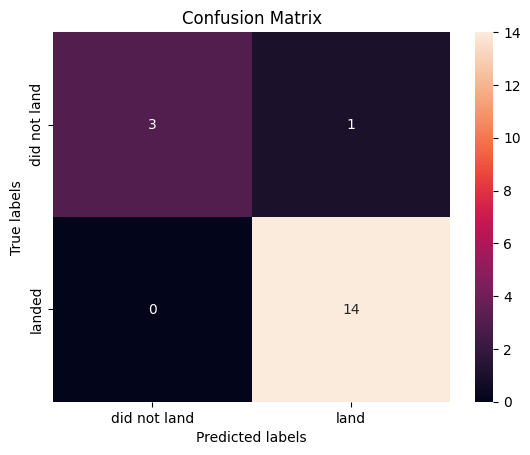

In [85]:
yhat_KNN = knn_cv.predict(X_test_scaled)
plot_confusion_matrix(Y_test,yhat_KNN)

In [86]:
knn_cv.score(X_test_scaled,Y_test)

0.9444444444444444

In [87]:
logreg_score = logreg_cv.score(X_test_scaled, Y_test)
svm_score = svm_cv.score(X_test_scaled, Y_test)
tree_score = tree_cv.score(X_test_scaled, Y_test)
knn_score = knn_cv.score(X_test_scaled, Y_test)

# Print the accuracy scores
print(f"Logistic Regression accuracy: {logreg_score}")
print(f"SVM accuracy: {svm_score}")
print(f"Decision Tree accuracy: {tree_score}")
print(f"KNN accuracy: {knn_score}")

# Find the best performing method
scores = {
    "Logistic Regression": logreg_score,
    "SVM": svm_score,
    "Decision Tree": tree_score,
    "KNN": knn_score
}

best_method = max(scores, key=scores.get)
print(f"The best performing method is: {best_method} with accuracy {scores[best_method]}")

Logistic Regression accuracy: 0.9444444444444444
SVM accuracy: 0.8888888888888888
Decision Tree accuracy: 0.8888888888888888
KNN accuracy: 0.9444444444444444
The best performing method is: Logistic Regression with accuracy 0.9444444444444444


In [93]:
print(logreg_cv.best_estimator_)
print(logreg_cv.best_params_)

LogisticRegression(C=0.01)
{'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}


In [95]:
best_model.score(X_test_scaled,Y_test)

0.9444444444444444

In [97]:
import joblib

In [91]:
joblib.dump(best_model,'SpaceX_Falcon9_first_stage_Landing_Prediction.pkl')

['SpaceX_Falcon9_first_stage_Landing_Prediction.pkl']